In [2]:
# !pip install transformers datasets evaluate sacrebleu torch accelerate

In [3]:
import time
import math
import torch
import psutil
from datasets import load_dataset
# from transformers import (
#     DistilGPT2TokenizerFast,
#     DistilGPT2LMHeadModel,
#     Trainer,
#     TrainingArguments
# )
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

model_name = "distilgpt2"

# tokenizer.pad_token = tokenizer.eos_token
# model.config.pad_token_id = tokenizer.eos_token_id

import evaluate


In [4]:
dataset = load_dataset("blended_skill_talk")

pairs = []

for item in dataset["train"]:
    if len(item["free_messages"]) >= 2:
        pairs.append({
            "prompt": item["free_messages"][0],
            "response": item["free_messages"][1]
        })

pairs = pairs[:5000]  # dummy scope


# Train / val / test split
train_pairs = pairs[:4000]
val_pairs   = pairs[4000:4500]
test_pairs  = pairs[4500:]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.88M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1009 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/980 [00:00<?, ? examples/s]

In [5]:
# tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")  old
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    texts = [p + tokenizer.eos_token + r for p, r in zip(batch["prompt"], batch["response"])]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=64)

from datasets import Dataset

train_ds = Dataset.from_list(train_pairs).map(tokenize, batched=True)
val_ds   = Dataset.from_list(val_pairs).map(tokenize, batched=True)
test_ds  = Dataset.from_list(test_pairs).map(tokenize, batched=True)

train_ds.set_format("torch")
val_ds.set_format("torch")
test_ds.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [6]:
# model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

In [7]:
training_args = TrainingArguments(
    output_dir="./dummy_llm",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # 👈 dummy
    logging_steps=50,
    save_strategy="no",
    report_to="none",
    learning_rate=5e-5
)

In [8]:
TOKENS = 64
FLOPS_PER_SAMPLE = 3.25e9 * 2  # forward + backward

num_samples = len(train_ds)
epochs = 3

estimated_flops = FLOPS_PER_SAMPLE * num_samples * epochs
print(f"Estimated training FLOPs: {estimated_flops:.2e}")

Estimated training FLOPs: 7.80e+13


In [ ]:
#TIME HOW LONG IT TAKES TO TRAIN

In [9]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

/tmp/ipython-input-4135377915.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,3.904000
100,3.749900
150,3.765400
200,3.787900
250,3.723600
300,3.663600
350,3.678500
400,3.685400
450,3.601800
500,3.646400


TrainOutput(global_step=5000, training_loss=3.1503744232177735, metrics={'train_runtime': 347.6831, 'train_samples_per_second': 57.524, 'train_steps_per_second': 14.381, 'total_flos': 326620938240000.0, 'train_loss': 3.1503744232177735, 'epoch': 5.0})

In [ ]:
# Zip the model directory
!zip -r {model_name}.zip ./{model_name}

# Download to local machine
from google.colab import files
files.download(f"{model_name}.zip")

	zip warning: name not matched: ./distilgpt2

zip error: Nothing to do! (try: zip -r distilgpt2.zip . -i ./distilgpt2)


FileNotFoundError: Cannot find file: distilgpt2.zip

In [ ]:
def chat(prompt, max_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        top_k=50,
        temperature=0.8
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    print("Dummy:", chat(user_input))

Dummy: please introduce yourself, i love to play with dolls. i have 2 kids so i'm thinking of going to iwoahawks. haha :/ i'm an actress, do you like to run in the morning? its tough to get jobs? dont you?


In [ ]:
output_dir = "./my_llm_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

output_dir = "./my_llm_model"

# Zip the model directory
!zip -r my_llm_model.zip {output_dir}

# Download to local machine
from google.colab import files
files.download("my_llm_model.zip")


Model and tokenizer saved to ./my_llm_model
  adding: my_llm_model/ (stored 0%)
  adding: my_llm_model/training_args.bin (deflated 53%)
  adding: my_llm_model/tokenizer.json (deflated 82%)
  adding: my_llm_model/special_tokens_map.json (deflated 60%)
  adding: my_llm_model/model.safetensors (deflated 7%)
  adding: my_llm_model/tokenizer_config.json (deflated 54%)
  adding: my_llm_model/merges.txt (deflated 53%)
  adding: my_llm_model/generation_config.json (deflated 31%)
  adding: my_llm_model/config.json (deflated 52%)
  adding: my_llm_model/vocab.json (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
eval_results = trainer.evaluate(test_ds)
loss = eval_results["eval_loss"]
perplexity = math.exp(loss)

print(f"Test Loss: {loss:.4f}")
print(f"Perplexity: {perplexity:.2f}")

Test Loss: 3.5029
Perplexity: 33.21


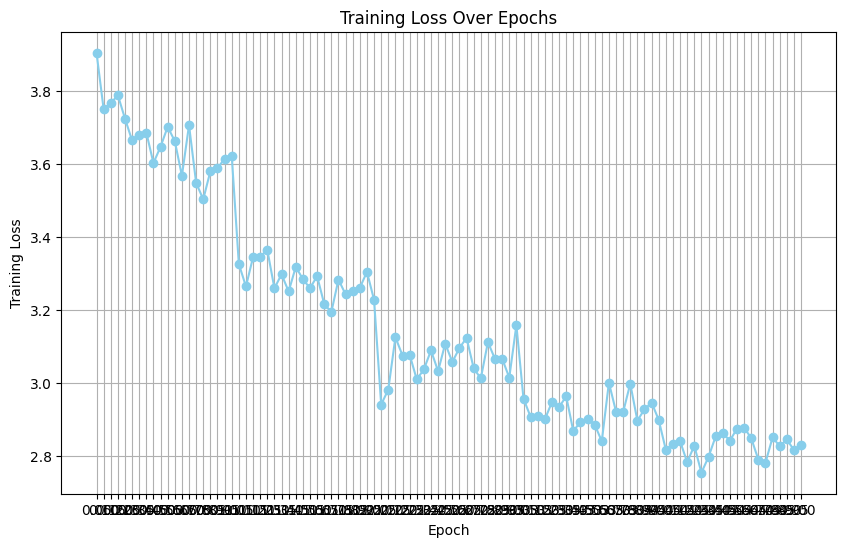

In [11]:
import matplotlib.pyplot as plt

# Extract training loss and epochs from trainer's log history
training_losses = []
epochs_recorded = []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        training_losses.append(log['loss'])
        epochs_recorded.append(log['epoch'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_recorded, training_losses, marker='o', linestyle='-', color='skyblue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.xticks(epochs_recorded) # Show ticks for each recorded epoch
plt.show()

In [12]:
bleu = evaluate.load("sacrebleu")

def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=True,
        top_k=50
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

preds, refs = [], []

for sample in test_pairs:
    pred = generate_response(sample["prompt"])
    preds.append(pred)
    refs.append([sample["response"]])

bleu_score = bleu.compute(predictions=preds, references=refs)
print("BLEU-2:", bleu_score["precisions"][1])


BLEU-2: 1.265001621796951
